<a href="https://colab.research.google.com/github/sachinkgp/calculating-SSC-suspended-Sedimentry-Concentration-using-remote-sensing/blob/master/Pract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The directory which gets printed after executing below cell should contain the data 

# Model 1

In [0]:
import os
os.getcwd()

'/content'

We Will use Seaborn for ploting plots between diffrent band Radiance and Suspended Sediment concentrations

In [0]:
!pip install seaborn

Tensorflow Will be used for the building deep neural network model,So we will import it

In [0]:
#using tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-shm9owmp
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-shm9owmp
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=82437 sha256=04dc0fa680f11a6294d5dd59401d0311c978e14b2020c6c0f60e990287eda76c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6l7ezucq/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


We will import few more libraries which will be required for our modelling

In [0]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.2.0-rc3


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from sklearn.model_selection import train_test_split

Loading the dataset
note here if the directory printed after executing 
**os.getcwd()**
does not contain the SSC_data.csv file than executing following cell will show error

In [0]:
df = pd.read_csv("SSC_data.csv")

using df.describe() we will see diffrent arithmatic parameters of the datasets

In [0]:
df.describe()

,B1,B2,B3,B4,B5,B7,n pixels,SSC
count,31452.000000,31452.000000,31452.000000,31452.000000,31452.000000,31452.000000,31452.000000,31452.000000
mean,626.312376,835.681175,858.961066,816.819106,267.731914,194.370148,367.156683,654.687527
std,276.622810,367.700314,477.099129,556.363579,187.094550,139.841375,1908.559668,3582.482626
min,90.000000,78.000000,39.000000,58.000000,-11.613861,-35.000000,1.000000,0.500000
25%,432.000000,577.000000,525.000000,452.900526,144.000000,100.000000,14.000000,39.675000
50%,572.000000,762.873494,738.000000,662.000000,219.000000,158.000000,44.000000,110.000000
75%,756.000000,1040.000000,1093.000000,986.500000,337.000000,248.500000,124.000000,302.190000
max,2835.000000,2844.000000,3462.000000,4270.000000,2153.000000,1922.000000,23166.000000,311000.000000


noticing that we have **mean value of 654** with **31452 datasets** and **75% values lies below 302** for SSC so we can remove some datapoints which lies in the higher range for better correlation

In [0]:
df.corr()

,B1,B2,B3,B4,B5,B7,n pixels,SSC
B1,1.000000,0.917251,0.815777,0.684967,0.550741,0.511785,-0.010130,0.269520
B2,0.917251,1.000000,0.956140,0.794985,0.582114,0.545755,0.017491,0.344504
B3,0.815777,0.956140,1.000000,0.845191,0.584439,0.554272,0.046325,0.384113
B4,0.684967,0.794985,0.845191,1.000000,0.672095,0.576612,-0.061697,0.478223
B5,0.550741,0.582114,0.584439,0.672095,1.000000,0.954824,-0.098754,0.233106
B7,0.511785,0.545755,0.554272,0.576612,0.954824,1.000000,-0.086338,0.159121
n pixels,-0.010130,0.017491,0.046325,-0.061697,-0.098754,-0.086338,1.000000,-0.024885
SSC,0.269520,0.344504,0.384113,0.478223,0.233106,0.159121,-0.024885,1.000000


Correlation value shows the dependies of two variables it varies between -1 and 1, **1 means variables are directly linearly depended on each other** and **-1 means inversly and linearly depended on each other**,a value of **0 mean two vaiables are not dependend at all**

We can see there is good correlation between **SSC and B3,B2 and B1** but still **not even 50%** correlated so we will reduce the dataset and remove higher values for better correlation

Now we will restrict our dataset to upper limit on SSC to only 2000 to increase the correlation further

In [0]:
# Loading dataset
df = df[df["SSC"]<=2000]
# Printing a Subset of the dataset 
df.head()

,B1,B2,B3,B4,B5,B7,n pixels,SSC
0,626.0,649.0,517.0,758.0,238.0,150.0,55,2.0
1,208.0,247.0,249.0,237.0,119.0,138.0,3,5.0
2,326.0,308.0,302.0,270.0,119.0,104.0,56,4.0
3,862.0,867.0,819.0,569.0,105.0,72.0,68,17.0
4,176.0,193.5,170.5,170.0,85.0,102.0,10,7.0


Correlation value shows the dependies of two variables it varies between -1 and 1, 1 means variables are directly linearly depended on each other and -1 means inversly and linearly depended on each other,a value of 0 mean two vaiables are not dependend at all

In [0]:
df.corr()

,B1,B2,B3,B4,B5,B7,n pixels,SSC
B1,1.000000,0.901843,0.779929,0.621317,0.498283,0.478801,0.004840,0.322494
B2,0.901843,1.000000,0.944546,0.721453,0.531121,0.524322,0.042648,0.448206
B3,0.779929,0.944546,1.000000,0.772518,0.530305,0.535221,0.081887,0.571492
B4,0.621317,0.721453,0.772518,1.000000,0.662603,0.590285,-0.051420,0.606022
B5,0.498283,0.531121,0.530305,0.662603,1.000000,0.957518,-0.096473,0.283275
B7,0.478801,0.524322,0.535221,0.590285,0.957518,1.000000,-0.082583,0.282771
n pixels,0.004840,0.042648,0.081887,-0.051420,-0.096473,-0.082583,1.000000,-0.037374
SSC,0.322494,0.448206,0.571492,0.606022,0.283275,0.282771,-0.037374,1.000000


Using the Correlat we hveion value of SSC with other variables we can see **SSC is depended 60% on B4,57% on B3,44% on B2 and 32% on B1**, So we will **first build a model on 3 Variables B1,B2,** and if error remains high than all 6 variables(B1,B2,B3,B4,B5,B7) will be used

We will describe diffrent arithmatic parameters of the datset now 

In [0]:
df.describe()

,B1,B2,B3,B4,B5,B7,n pixels,SSC
count,29949.000000,29949.000000,29949.000000,29949.000000,29949.000000,29949.000000,29949.000000,29949.000000
mean,603.968300,798.129789,804.238144,738.463175,254.168066,186.395289,383.882267,221.550314
std,252.828605,316.125228,399.402548,405.085300,169.624194,131.421198,1954.331931,319.178613
min,90.000000,78.000000,39.000000,58.000000,-11.613861,-35.000000,1.000000,0.500000
25%,426.000000,568.000000,516.000000,443.846532,141.000000,97.066667,15.000000,37.000000
50%,558.172414,744.000000,713.000000,639.000000,213.000000,154.000000,46.000000,100.000000
75%,732.000000,998.000000,1021.000000,930.000000,322.000000,238.000000,128.000000,258.000000
max,2835.000000,2751.000000,2701.000000,3296.000000,1729.000000,1447.000000,23166.000000,2000.000000


We hve a total of almost 30thousand datasets.We can see we have restricted the dataset to upper value of 2000 for SSC.We can also observe that 75% values lies below 258 so 2000 is a well upper bound on this.
Also mean of the values is 221.

In [0]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29949 entries, 0 to 31451
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   B1        29949 non-null  float64
 1   B2        29949 non-null  float64
 2   B3        29949 non-null  float64
 3   B4        29949 non-null  float64
 4   B5        29949 non-null  float64
 5   B7        29949 non-null  float64
 6   n pixels  29949 non-null  int64  
 7   SSC       29949 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 2.1 MB
None


We will seprarte the dataset into X and y, where X will contain B1,B2,B3 and y will contain SSC values

In [0]:
X = df.iloc[:,:6]

In [0]:
y = df.SSC

We will describe the diffrent arithamtic values of the depended datasets X

In [0]:
X.describe()

,B1,B2,B3
count,29949.000000,29949.000000,29949.000000
mean,603.968300,798.129789,804.238144
std,252.828605,316.125228,399.402548
min,90.000000,78.000000,39.000000
25%,426.000000,568.000000,516.000000
50%,558.172414,744.000000,713.000000
75%,732.000000,998.000000,1021.000000
max,2835.000000,2751.000000,2701.000000


We will devide dataset into 2 parts train and test we will devolope our model on train data and we will predict values of test dataset and than compare it to actual dataset to improve our existing model

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now we will plot Diffrent values against each other on a plot to check their dependency

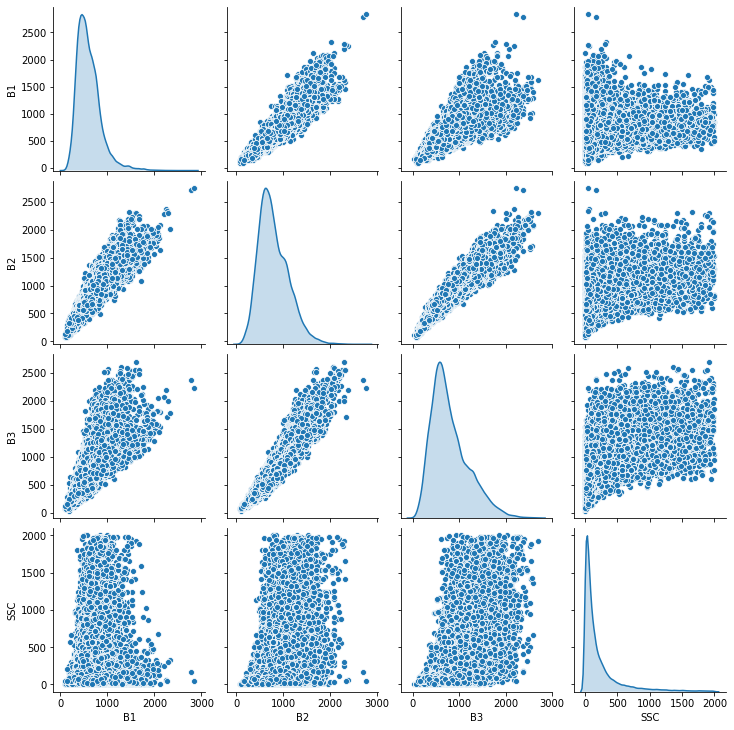

In [0]:
sns.pairplot(df[["B1", "B2", "B3","SSC"]], diag_kind="kde")

From the plots we can observe that there is a strong dependency of the variables among themselves and also thee dependency between SSC and diffrent bands if not that prominent.

Using linear regression will not give fruitful results as there is no linear correlation between diffrent variables and SSC values so we will try deep neural network 

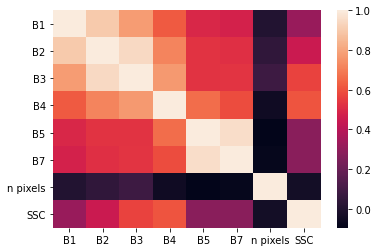

In [0]:
sns.heatmap(df.corr())

#JOINT PLOT#
We will be plot diffrent variables against SSC value and look for these plots for additional inputs

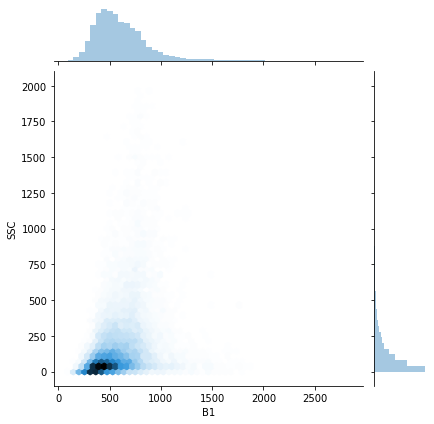

In [0]:
#ploting B1 against SSC
sns.jointplot(x='B1',y='SSC',data=df,kind='hex')

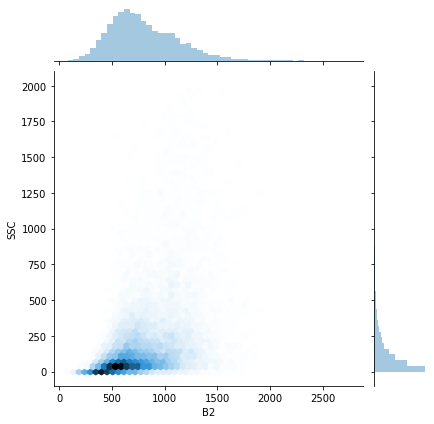

In [0]:
#ploting B1 against SSC
sns.jointplot(x='B2',y='SSC',data=df,kind='hex')

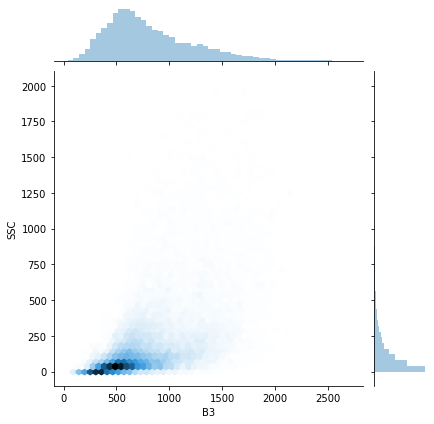

In [0]:
#ploting B1 against SSC
sns.jointplot(x='B3',y='SSC',data=df,kind='hex')

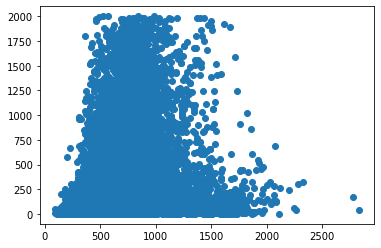

In [0]:
#ploting B1 against SSC
plt.scatter(df['B1'],df['SSC'])

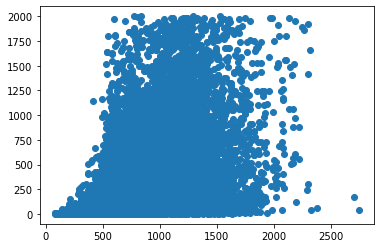

In [0]:
#ploting B2 against SSC
plt.scatter(df['B2'],df['SSC'])

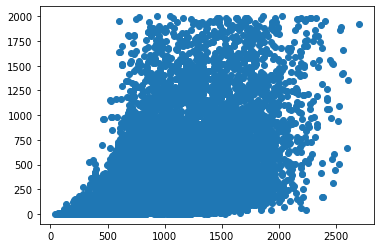

In [0]:
#ploting B3 against SSC
plt.scatter(df['B3'],df['SSC'])

In [0]:
y.head()

0     2.0
1     5.0
2     4.0
3    17.0
4     7.0
Name: SSC, dtype: float64

In [0]:
train_stats = X_train.describe()
train_stats = train_stats.transpose()

We can see we have values of randiation bands lying between 0 and thoudsand.
we will scale these values using their mean and standard deviation so that most of them lie between -2 and 2

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(X_train)
normed_test_data = norm(X_test)

looking into the normalised dataset

In [0]:
normed_train_data.describe()

,B1,B2,B3
count,2.395900e+04,2.395900e+04,2.395900e+04
mean,-4.612083e-15,3.370293e-15,-4.798940e-15
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.027599e+00,-2.269630e+00,-1.912206e+00
25%,-7.045093e-01,-7.276388e-01,-7.203253e-01
50%,-1.792229e-01,-1.731101e-01,-2.305796e-01
75%,5.040443e-01,6.314579e-01,5.440181e-01
max,8.813837e+00,6.159292e+00,4.739339e+00


Now we will build a deep neural net model

In [0]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(3,)))
model.add(Dense(80, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(20, activation='linear'))
model.add(Dense(1, activation='linear'))

In [0]:
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile( loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 9,881
Trainable params: 9,881
Non-trainable params: 0
_________________________________________________________________


In [0]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.33924407],
       [-0.4171819 ],
       [-0.25179514],
       [-0.46671143],
       [-0.23894279],
       [-0.18336742],
       [-0.15457505],
       [-0.5197503 ],
       [-0.6046521 ],
       [-0.2877176 ]], dtype=float32)

In [0]:
model.fit(normed_train_data, y_train,epochs=20, batch_size=32, verbose=1)

Epoch 1/20
23959/23959 [==============================] - 1s 42us/step - loss: 56952.2160 - mae: 139.1318 - mse: 56952.1875
Epoch 2/20
23959/23959 [==============================] - 1s 42us/step - loss: 56702.1674 - mae: 138.6758 - mse: 56702.1445
Epoch 3/20
23959/23959 [==============================] - 1s 43us/step - loss: 56707.4284 - mae: 138.8543 - mse: 56707.4570
Epoch 4/20
23959/23959 [==============================] - 1s 43us/step - loss: 56688.6518 - mae: 138.7408 - mse: 56688.6250
Epoch 5/20
23959/23959 [==============================] - 1s 42us/step - loss: 56541.6093 - mae: 138.5247 - mse: 56541.5625
Epoch 6/20
23959/23959 [==============================] - 1s 42us/step - loss: 56487.3333 - mae: 138.0966 - mse: 56487.3203
Epoch 7/20
23959/23959 [==============================] - 1s 43us/step - loss: 56327.1414 - mae: 138.3508 - mse: 56327.1211
Epoch 8/20
23959/23959 [==============================] - 1s 42us/step - loss: 56384.9885 - mae: 138.3667 - mse: 56384.9961
Epoch 9/

In [0]:
y_pred = model.predict(normed_test_data)

In [0]:
y_test.describe()

count    5990.000000
mean      218.932038
std       317.144991
min         0.500000
25%        36.225000
50%        98.000000
75%       254.000000
max      2000.000000
Name: SSC, dtype: float64

In [0]:
y_pred = pd.DataFrame(data=y_pred);

In [0]:
y_pred.describe()

,0
count,5990.000000
mean,229.333618
std,232.947525
min,-11.685219
25%,71.515284
50%,134.119926
75%,320.362923
max,1507.207397


In [0]:
k=0
for i in range(len(y_pred)):
    k+=(y_pred.iloc[i]-y_test.iloc[i])**2
k/=len(y_pred)
k

0    58477.835938
Name: 0, dtype: float32

In [0]:
keras.backend.clear_session()

#Our model Perform badly so we will include all 6 variables and see results

In [0]:
df = pd.read_csv("SSC_data.csv")
df = df[df["SSC"]<=2000] 
df.head()
X = df.iloc[:,:3]
y = df.SSC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
normed_train_data = norm(X_train)
normed_test_data = norm(X_test)

NameError: ignored

In [0]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(3,)))
model.add(Dense(80, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(20, activation='linear'))
model.add(Dense(1, activation='linear'))
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile( loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 9,881
Trainable params: 9,881
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(normed_train_data, y_train,epochs=20, batch_size=32, verbose=1)

Epoch 1/20
23959/23959 [==============================] - 1s 44us/step - loss: 74579.7528 - mae: 162.2664 - mse: 74579.7969
Epoch 2/20
23959/23959 [==============================] - 1s 42us/step - loss: 61250.5769 - mae: 146.9607 - mse: 61250.6211
Epoch 3/20
23959/23959 [==============================] - 1s 43us/step - loss: 58606.2165 - mae: 142.6797 - mse: 58606.3047
Epoch 4/20
23959/23959 [==============================] - 1s 42us/step - loss: 58042.0465 - mae: 140.5215 - mse: 58042.0781
Epoch 5/20
23959/23959 [==============================] - 1s 42us/step - loss: 57710.7624 - mae: 139.6763 - mse: 57710.7422
Epoch 6/20
23959/23959 [==============================] - 1s 42us/step - loss: 57531.9370 - mae: 139.4456 - mse: 57531.9141
Epoch 7/20
23959/23959 [==============================] - 1s 44us/step - loss: 57382.7277 - mae: 139.1308 - mse: 57382.7500
Epoch 8/20
23959/23959 [==============================] - 1s 43us/step - loss: 57287.2558 - mae: 138.7016 - mse: 57287.2422
Epoch 9/

**For a brief moment lets switch to SVR**

In [0]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,coef0=1)
lw = 2

In [0]:
sp_clf = SVR( degree=5 )
sp_clf.fit( sp_tr[:,[i_x]], sp_tr[:,i_y] )
ys = sp_clf.predict( numpy.transpose([xs]) )

In [0]:
svr_poly.fit(normed_train_data,y_train)

SVR(C=100, cache_size=200, coef0=1, degree=3, epsilon=0.1, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred = svr_poly.predict(X_test)

In [0]:
k=0
for i in range(len(y_pred)):
  print(y_pred[i]-y_test.iloc[i])
  k+=((y_pred[i]-y_test.iloc[i])**2)
k/=(len(y_pred))

In [0]:

k

4.485441405052655e+19

In [0]:
svr_rbf.fit(X_train,y_train)
y_pred = svr_rbf.predict(X_test)
y_pred[0:10]

array([118.76239182, 118.76289202, 118.76289202, 112.98475879,
       118.76289202, 118.76289202, 118.76289202, 118.76289202,
       118.76289202, 118.76289202])

In [0]:
y_test.iloc[0:10]

13411     45.0
20212    209.0
11455     43.4
12333     49.6
7493      29.6
22264    475.0
13992     95.0
19138    400.0
1861      42.0
17403    211.0
Name: SSC, dtype: float64

In [0]:
for i in range(10):
  print(y_pred[i])

2975499944.036861
7717936344.361403
2187648833.561332
410369789.56091106
1305889628.1726604
608454865.9890445
790720890.710441
-4067943529.141724
2443510096.785438
690627246.506286


In [0]:
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

Not a Great Experience with SVR

In [0]:
data = df.copy()
data=data[data['SSC']<3000]

In [0]:
data.head()

,B1,B2,B3,B4,B5,B7,n pixels,SSC
0,626.0,649.0,517.0,758.0,238.0,150.0,55,2.0
1,208.0,247.0,249.0,237.0,119.0,138.0,3,5.0
2,326.0,308.0,302.0,270.0,119.0,104.0,56,4.0
3,862.0,867.0,819.0,569.0,105.0,72.0,68,17.0
4,176.0,193.5,170.5,170.0,85.0,102.0,10,7.0


In [0]:
data.describe()

,B1,B2,B3,B4,B5,B7,n pixels,SSC
count,29949.000000,29949.000000,29949.000000,29949.000000,29949.000000,29949.000000,29949.000000,29949.000000
mean,603.968300,798.129789,804.238144,738.463175,254.168066,186.395289,383.882267,221.550314
std,252.828605,316.125228,399.402548,405.085300,169.624194,131.421198,1954.331931,319.178613
min,90.000000,78.000000,39.000000,58.000000,-11.613861,-35.000000,1.000000,0.500000
25%,426.000000,568.000000,516.000000,443.846532,141.000000,97.066667,15.000000,37.000000
50%,558.172414,744.000000,713.000000,639.000000,213.000000,154.000000,46.000000,100.000000
75%,732.000000,998.000000,1021.000000,930.000000,322.000000,238.000000,128.000000,258.000000
max,2835.000000,2751.000000,2701.000000,3296.000000,1729.000000,1447.000000,23166.000000,2000.000000


In [0]:
data.corr()

,B1,B2,B3,B4,B5,B7,n pixels,SSC
B1,1.000000,0.901843,0.779929,0.621317,0.498283,0.478801,0.004840,0.322494
B2,0.901843,1.000000,0.944546,0.721453,0.531121,0.524322,0.042648,0.448206
B3,0.779929,0.944546,1.000000,0.772518,0.530305,0.535221,0.081887,0.571492
B4,0.621317,0.721453,0.772518,1.000000,0.662603,0.590285,-0.051420,0.606022
B5,0.498283,0.531121,0.530305,0.662603,1.000000,0.957518,-0.096473,0.283275
B7,0.478801,0.524322,0.535221,0.590285,0.957518,1.000000,-0.082583,0.282771
n pixels,0.004840,0.042648,0.081887,-0.051420,-0.096473,-0.082583,1.000000,-0.037374
SSC,0.322494,0.448206,0.571492,0.606022,0.283275,0.282771,-0.037374,1.000000


In [0]:
X = data.iloc[:,:6]
y = data.SSC

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [0]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(6,)))
model.add(Dense(80, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(20, activation='linear'))
model.add(Dense(1, activation='linear'))
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile( loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                140       
_________________________________________________________________
dense_2 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 9,941
Trainable params: 9,941
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X_train,y_train,epochs=10,batch_size= 100)

In [0]:
y_pred = model.predict(X_test)

In [0]:
y_test_np = y_test.to_numpy()

In [0]:
np.sqrt(np.mean(y_test_np-y_pred)**2)

41.998106788443266

lets make a better model

In [0]:
keras.backend.clear_session()
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(6,)))
model.add(Dense(80, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='relu'))
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile( loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                140       
_________________________________________________________________
dense_2 (Dense)              (None, 800)               16800     
_________________________________________________________________
dense_3 (Dense)              (None, 800)               640800    
_________________________________________________________________
dense_4 (Dense)              (None, 20)                16020     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 673,781
Trainable params: 673,781
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X_train,y_train,epochs=10,batch_size= 100)

Epoch 1/10
23959/23959 [==============================] - 4s 148us/step - loss: 56589.6207 - mae: 146.4671 - mse: 56589.6016
Epoch 2/10
23959/23959 [==============================] - 3s 145us/step - loss: 50803.3517 - mae: 133.1578 - mse: 50803.3438
Epoch 3/10
23959/23959 [==============================] - 4s 168us/step - loss: 48864.3983 - mae: 129.2200 - mse: 48864.3945
Epoch 4/10
23959/23959 [==============================] - 6s 268us/step - loss: 47638.3050 - mae: 127.0843 - mse: 47638.3047
Epoch 5/10
23959/23959 [==============================] - 6s 252us/step - loss: 46758.2200 - mae: 125.1646 - mse: 46758.2148
Epoch 6/10
23959/23959 [==============================] - 3s 144us/step - loss: 46348.2093 - mae: 124.8197 - mse: 46348.2031
Epoch 7/10
23959/23959 [==============================] - 4s 146us/step - loss: 46019.2907 - mae: 124.2403 - mse: 46019.3008
Epoch 8/10
23959/23959 [==============================] - 3s 145us/step - loss: 45657.9839 - mae: 123.3800 - mse: 45657.9922


In [0]:
y_pred = model.predict(X_test)

In [0]:
y_pred[0:20];

In [0]:
y_test.head(20);

# Model 2

In [0]:
data1 = df.copy()
data1 = data1[data1['SSC']>=10]
data1 = data1[data1['SSC']<=200]
X = data1.iloc[:,:6]
y = data1.SSC
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [0]:
y_train.describe()

count    14407.000000
mean        78.099194
std         51.700485
min         10.000000
25%         35.000000
50%         66.000000
75%        115.000000
max        200.000000
Name: SSC, dtype: float64

In [0]:
data1.describe()

,B1,B2,B3,B4,B5,B7,n pixels,SSC
count,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000
mean,571.066745,746.250263,703.875384,621.945143,232.324808,168.594138,480.974624,77.830701
std,241.564075,267.829125,293.872678,290.466689,137.549613,106.370801,2344.271362,51.608447
min,92.655738,124.000000,97.000000,58.000000,-11.613861,-11.000000,1.000000,10.000000
25%,408.000000,553.000000,496.000000,415.000000,138.000000,94.765625,16.000000,35.000000
50%,520.272727,696.000000,639.000000,558.000000,206.000000,146.000000,48.000000,65.800000
75%,673.000000,899.000000,859.500000,762.500000,297.000000,219.000000,128.000000,114.000000
max,2835.000000,2751.000000,2387.000000,3296.000000,1729.000000,1369.000000,23166.000000,200.000000


In [0]:
keras.backend.clear_session()

In [0]:
keras.backend.clear_session()
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(6,)))
model.add(Dense(80, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='relu'))
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile( loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                140       
_________________________________________________________________
dense_2 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 9,941
Trainable params: 9,941
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X_train,y_train,epochs=10,batch_size= 10)

Epoch 1/10
14407/14407 [==============================] - 2s 134us/step - loss: 2280.9296 - mae: 36.9878 - mse: 2280.9304
Epoch 2/10
14407/14407 [==============================] - 2s 131us/step - loss: 2166.3287 - mae: 36.0582 - mse: 2166.3281
Epoch 3/10
14407/14407 [==============================] - 2s 130us/step - loss: 2132.0599 - mae: 35.8221 - mse: 2132.0605
Epoch 4/10
14407/14407 [==============================] - 2s 144us/step - loss: 2103.6662 - mae: 35.6712 - mse: 2103.6653
Epoch 5/10
14407/14407 [==============================] - 2s 139us/step - loss: 2090.0688 - mae: 35.4656 - mse: 2090.0671
Epoch 6/10
14407/14407 [==============================] - 2s 141us/step - loss: 2058.0685 - mae: 35.2781 - mse: 2058.0684
Epoch 7/10
14407/14407 [==============================] - 2s 135us/step - loss: 2049.7567 - mae: 35.2878 - mse: 2049.7566
Epoch 8/10
14407/14407 [==============================] - 2s 139us/step - loss: 2019.7212 - mae: 35.1077 - mse: 2019.7198
Epoch 9/10
14407/14407 [

In [0]:
y_pred = model.predict(X_test)

In [0]:
k= 0
for i in range(10):
  print(str(y_pred[i])+' , '+str(y_test.iloc[i]))

[75.44442] , 107.0
[75.00542] , 70.0
[44.23905] , 26.0
[40.19774] , 20.0
[68.4505] , 77.5
[122.41257] , 190.0
[129.65317] , 194.0
[94.584274] , 192.0
[53.6709] , 10.0
[120.93801] , 64.0


# Model 3

In [0]:
data1 = df.copy()
data1 = data1[data1['SSC']>=10]
data1 = data1[data1['SSC']<=400]
X = data1.iloc[:,:6]
y = data1.SSC
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
keras.backend.clear_session()
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(6,)))
model.add(Dense(80, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='relu'))
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile( loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

In [0]:
model.fit(X_train,y_train,epochs=10,batch_size= 10)

Epoch 1/10
18096/18096 [==============================] - 3s 147us/step - loss: 7537.6197 - mae: 64.7236 - mse: 7537.6206
Epoch 2/10
18096/18096 [==============================] - 2s 138us/step - loss: 7057.3678 - mae: 62.5628 - mse: 7057.3691
Epoch 3/10
18096/18096 [==============================] - 2s 134us/step - loss: 6760.0427 - mae: 61.3711 - mse: 6760.0439
Epoch 4/10
18096/18096 [==============================] - 2s 132us/step - loss: 6673.6167 - mae: 61.0533 - mse: 6673.6123
Epoch 5/10
18096/18096 [==============================] - 2s 132us/step - loss: 6552.2560 - mae: 60.6589 - mse: 6552.2549
Epoch 6/10
18096/18096 [==============================] - 2s 128us/step - loss: 6474.6688 - mae: 60.4697 - mse: 6474.6719
Epoch 7/10
18096/18096 [==============================] - 2s 130us/step - loss: 6464.7400 - mae: 60.7384 - mse: 6464.7388
Epoch 8/10
18096/18096 [==============================] - 2s 136us/step - loss: 6408.9873 - mae: 60.6174 - mse: 6408.9888
Epoch 9/10
18096/18096 [

# Model 4

In [0]:
from array import *
my_array = array('i', [])

In [0]:
for i in range(10000):
  data1 = df.copy()
  data1 = data1[data1['SSC']>=94]
  data1 = data1[data1['SSC']<=(400)]
  X = data1.iloc[:,:6]
  y = data1.SSC
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
  keras.backend.clear_session()
  from keras.models import Sequential
  from keras.layers import Dense
  model = Sequential()
  model.add(Dense(20, activation='softmax', input_shape=(6,)))
  model.add(Dense(80, activation='linear'))
  model.add(Dense(80, activation='softmax'))
  model.add(Dense(20, activation='linear'))
  model.add(Dense(1, activation='relu'))
  optimizer = tf.keras.optimizers.Adam((1/(i+1)))
  model.compile( loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  model.fit(X_train,y_train,epochs=10,batch_size= 1000)
  y_pred = model.predict(X_test)
  y_test1 = y_test.to_numpy()
  k = 0
  for i in range(len(y_pred)):
    k+=((y_pred[i]-y_test1[i])**2)
  k /=len(y_pred)
  my_array.append(np.sqrt(k))
  

Using TensorFlow backend.


Streaming output truncated to the last 5000 lines.
8613/8613 [==============================] - 0s 11us/step - loss: 47263.5369 - mae: 200.8574 - mse: 47263.5391
Epoch 2/10
8613/8613 [==============================] - 0s 5us/step - loss: 47243.0853 - mae: 200.8066 - mse: 47243.0820
Epoch 3/10
8613/8613 [==============================] - 0s 5us/step - loss: 47221.9036 - mae: 200.7537 - mse: 47221.9062
Epoch 4/10
8613/8613 [==============================] - 0s 5us/step - loss: 47199.6813 - mae: 200.6985 - mse: 47199.6836
Epoch 5/10
8613/8613 [==============================] - 0s 5us/step - loss: 47176.2844 - mae: 200.6401 - mse: 47176.2812
Epoch 6/10
8613/8613 [==============================] - 0s 5us/step - loss: 47151.3164 - mae: 200.5780 - mse: 47151.3164
Epoch 7/10
8613/8613 [==============================] - 0s 5us/step - loss: 47124.6712 - mae: 200.5114 - mse: 47124.6719
Epoch 8/10
8613/8613 [==============================] - 0s 5us/step - loss: 47095.9490 - mae: 200.4398 - mse: 47

In [0]:
my_array

array('i', [146, 148, 149, 97, 149, 98, 97, 152, 153, 153, 97, 155, 96, 156, 156, 98, 96, 159, 97, 160, 95, 162, 161, 160, 164, 163, 166, 95, 167, 94, 95, 167, 94, 95, 95, 95, 94, 174, 173, 93, 93, 93, 93, 92, 93, 181, 182, 92, 185, 91, 92, 92, 92, 90, 90, 90, 90, 190, 190, 91, 90, 190, 89, 89, 192, 194, 195, 88, 89, 200, 88, 197, 87, 200, 87, 87, 201, 86, 208, 207, 207, 209, 207, 85, 209, 85, 208, 84, 211, 215, 211, 84, 84, 80, 216, 81, 217, 80, 220, 221, 58, 58, 59, 59, 59, 59, 58, 60, 184, 186, 61, 61, 61, 62, 187, 62, 61, 189, 63, 190, 63, 63, 189, 64, 64, 64, 65, 190, 65, 65, 194, 65, 193, 196, 194, 67, 67, 196, 67, 69, 68, 196, 68, 199, 68, 70, 68, 68, 69, 202, 71, 70, 70, 72, 70, 72, 203, 202, 73, 73, 72, 73, 204, 208, 207, 208, 75, 206, 207, 75, 208, 210, 75, 77, 76, 77, 76, 79, 212, 212, 78, 212, 79, 213, 210, 79, 215, 213, 212, 214, 213, 79, 82, 81, 83, 81, 214, 216, 217, 82, 83, 82, 216, 82, 217, 217, 84])

In [0]:
my_array.index(58)

100

In [0]:
my_array

array('i', [146, 148, 149, 97, 149, 98, 97, 152, 153, 153, 97, 155, 96, 156, 156, 98, 96, 159, 97, 160, 95, 162, 161, 160, 164, 163, 166, 95, 167, 94, 95, 167, 94, 95, 95, 95, 94, 174, 173, 93, 93, 93, 93, 92, 93, 181, 182, 92, 185, 91, 92, 92, 92, 90, 90, 90, 90, 190, 190, 91, 90, 190, 89, 89, 192, 194, 195, 88, 89, 200, 88, 197, 87, 200, 87, 87, 201, 86, 208, 207, 207, 209, 207, 85, 209, 85, 208, 84, 211, 215, 211, 84, 84, 80, 216, 81, 217, 80, 220, 221])

In [0]:
for i in range(4):
  print(i)

0
1
2
3


#Best model till now


In [0]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(6,)))
model.add(Dense(800, activation='relu'))
model.add(Dense(800, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='relu'))
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile( loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
model.summary()